In [1]:
from hw2skeleton import io, cluster, utils
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from itertools import product
import pandas as pd
from sklearn.decomposition import PCA

Read in 136 active sites


In [2]:
#path = '/Users/Sisi/Documents/GitHub/BMI-203-HW2/data' #Note: may have to change the path when uploading into GitHub?
path = '/Users/sierra.lear/Documents/GitHub/BMI-203-HW2/data'

active_site = io.read_active_sites(path);

Read in 136 active sites


## Objective #1:
*Implement a similarity metric to compare active sites.*

For my similarity metric, I want to calculate the percentage of a given amino acid in an active site (basically, the compositionality of an active site). I can then calculate the Euclidan distance based on the 20-D space constructed by the ratio of all 20 different amino acids.

One one hand, this obviously simplifies or "ignores" important functional information, namely the 3D structure/configuration of amino acids or residues in relation to each other as well as the number of residues or how "large" an active site is.

However, given my inexperience with enzyme function, I am hypothesizing that the overall "chemical identity" of a residue still gives an important clue to its function--in particular, two active sites that contain more of the same amino acids are more likely to be functionally similar or have similar roles than two residues that contain no overlapping amino acids. Furthermore, given that some amino acids have specific charges or hydrophobicity, I know that amino acids often drive structure, so I also hypothesize that some of this "lost" structural information will actually be redundant or contained within the ratio or identity of amino acids anyway.

In [3]:
combos = list(product(range(0,len(active_site)), range(0,len(active_site))))

In [4]:
my_aa = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU', 'LYS',
         'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']

def compute_similarity(site_a, site_b):
    """
    Compute the similarity between two given ActiveSite instances.

    Input: two ActiveSite instances
    Output: the similarity between them (a floating point number)
    """

    similarity = 0.0
    
    #creating list comprehension of all AAs for site a residues
    list_res_a = [r.type for r in site_a.residues]
    
    #creating list comprehension of all AAs for site b residues
    list_res_b = [r.type for r in site_b.residues]
    
    #create two histogram count lists for site a and b from the list comprehensions
    count_a = Counter(list_res_a)
    count_b = Counter(list_res_b)
    
    #initialize two 20-element AA dictionaries: one for site A, one for site B
    a_dict = {aa:0 for aa in my_aa}
    b_dict = {aa:0 for aa in my_aa}
    
    #convert normalized histogram count into the 20-D vector AA dictionary
    #a site
    for aa, count in count_a.items():
        a_dict[aa] = count
    a_vector = np.array(list(a_dict.values()))
    a_vector = a_vector/np.sum(a_vector) #to return percentage of amino acid identity
    #b site
    for aa, count in count_b.items():
        b_dict[aa] = count
    b_vector = np.array(list(b_dict.values()))
    b_vector = b_vector/np.sum(b_vector)
        
    #calculate Euclidian distance between the two sites' 20-D vectors
    similarity = np.sqrt(np.sum((a_vector - b_vector)**2))
    
    return similarity

In [5]:
a = compute_similarity(active_site[53], active_site[4])
a

0.7810104508027012

In [6]:
a = compute_similarity(active_site[3], active_site[4])
a

0.2939723678960656

In [7]:
df = pd.DataFrame(columns = ['Site_A', 'Site_B', 'Similarity'])
for a, b in combos:
    similarity = compute_similarity(active_site[a], active_site[b])
    df = df.append({'Site_A': a, 'Site_B': b, 'Similarity': similarity}, ignore_index=True)
df.head()

,Site_A,Site_B,Similarity
0,0.0,0.0,0.000000
1,0.0,1.0,0.435135
2,0.0,2.0,0.404061
3,0.0,3.0,0.409019
4,0.0,4.0,0.365769


In [8]:
df = df.loc[~(df["Site_A"] == df["Site_B"]), :] #remove all rows where Site_A == Site_B
df.tail()

,Site_A,Site_B,Similarity
18490,135.0,130.0,0.439697
18491,135.0,131.0,0.527046
18492,135.0,132.0,0.543984
18493,135.0,133.0,0.527046
18494,135.0,134.0,0.955685


Below I've plotted a histogram containing the distances of all my active sites compared to every other active site. This histogram gives me the idea of what the overall distribution of my active sites--based on this specific similarity metric--might be.

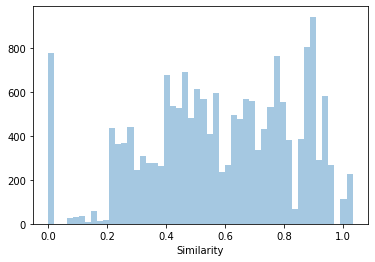

In [9]:
sns.distplot(df["Similarity"], bins=50, norm_hist=False, kde=False)

## Objective #2: 
*Implement a partitioning algorithm to cluster the set of active sites.* 


My similarity metric in Objective #1 was designed to work only with the active site pdb files and not with randomized centroids, so I've made a slightly modified similarity metric function that is able to work with a centroid (seen below) in order to properly complete this objective.

In [11]:
my_aa = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU', 'LYS',
         'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']

def compute_similarity_partitioning(site_a, centroid):
    """
    Compute the similarity between two given ActiveSite instances.

    Input: one ActiveSite instance, one "centroid" consisting of a 20-element vector with numnbers between 0 and 1
    Output: the similarity between them (a floating point number)
    """

    similarity = 0.0
    
    #creating list comprehension of all AAs for site a residues
    list_res_a = [r.type for r in site_a.residues]
    
    #create two histogram count lists for site a and b from the list comprehensions
    count_a = Counter(list_res_a)
    
    #initialize two 20-element AA dictionaries: one for site A, one for site B
    a_dict = {aa:0 for aa in my_aa}
    
    #convert normalized histogram count into the 20-D vector AA dictionary
    #a site
    for aa, count in count_a.items():
        a_dict[aa] = count
    a_vector = np.array(list(a_dict.values()))
    a_vector = a_vector/np.sum(a_vector) #to return percentage of amino acid identity
        
    #calculate Euclidian distance between the two sites' 20-D vectors
    similarity = np.sqrt(np.sum((a_vector - centroid)**2))
    
    return similarity, a_vector

In [12]:
def cluster_by_partitioning(active_sites):
    """
    Cluster a given set of ActiveSite instances using a partitioning method.
    Input: a list of ActiveSite instances
    Output: a clustering of ActiveSite instances
            (this is really a list of clusters, each of which is list of
            ActiveSite instances)
    """

    #number of clusters
    k = 3 #based off histogram--while an elbow plot would be a better way to pick clusters, I chose
              #this for the sake of brevity
    
    #creating random centroids
        # my centroid will be a 20-element vector with randomized numbers between 0 and 1
    np.random.seed(3) #seed
    centroid_list = [None] * k #initializing my list of k centroids
    for i in range(len(centroid_list)): 
        centroid_list[i] = np.random.rand(20) #creatign random numbers to fill 20 elements of each centroid vector
        centroid_list[i] /= centroid_list[i].sum() #to ensure all elements sum to 1 to mimic amino acid compositionality

    
    #k-means algorithm    
    partition_combos = list(product(range(0,len(active_site)), range(0,len(centroid_list)))) #create list of tuples
                                                                                          #with all combinations of
                                                                                #active site instances and centroids
    for iter in range(100):    #running KNN 100 times before stopping
        df = pd.DataFrame(columns = ['ActiveSite', 'Centroids', 'Similarity']) #initialize dataframe
        a_list = [] #initialize list of the compositionality of all amino acids
        for a, b in partition_combos:
            similarity, a_vector = compute_similarity_partitioning(active_site[a], centroid_list[b]) #calculate distances between all centroids and all active sites
            df = df.append({'ActiveSite': a, 'Centroids': b, 'Similarity': similarity}, ignore_index=True) #create df listing distance to each centroid for each amino acid
            a_list.append(a_vector) #create list of compositionality of all amino acids
    
        #labeling each ActiveSite to a centroid based on having the lowest similarity score
        df_new = df.sort_values("Similarity").groupby("ActiveSite").first() #assigns active site to closest centroid
    
        #recalculate centroid based on active site assigned to it
        clusterings = [] #initialize clusterings list
        for centroid in df_new["Centroids"].unique(): #looping through each centroid 
            as_in_centroids = df_new.loc[df_new["Centroids"] == centroid].index #find all active site labelled for that cluster
            clusterings.append(as_in_centroids.tolist()) #add that to my clustering list
            centroid_activesite_comps = [] #intialize list of compositionality for a given centroid
            for activesite in as_in_centroids: #lopping through each active site for a given centroid
                centroid_activesite_comps.append(a_list[int(activesite)]) #adding given active site's 20-element vector to list
            centroid_list[i] = np.mean(centroid_activesite_comps, axis = 0) #recalculating centroid as the row element-wise mean of the new amino acids
                
    return clusterings

In [13]:
partition_cluster = cluster_by_partitioning(active_site)
partition_cluster

[[0.0,
  2.0,
  5.0,
  6.0,
  8.0,
  9.0,
  10.0,
  12.0,
  13.0,
  14.0,
  15.0,
  16.0,
  17.0,
  24.0,
  26.0,
  27.0,
  28.0,
  31.0,
  32.0,
  33.0,
  36.0,
  37.0,
  38.0,
  41.0,
  42.0,
  43.0,
  44.0,
  45.0,
  46.0,
  47.0,
  50.0,
  51.0,
  52.0,
  54.0,
  55.0,
  58.0,
  59.0,
  60.0,
  62.0,
  63.0,
  65.0,
  66.0,
  68.0,
  70.0,
  72.0,
  74.0,
  75.0,
  76.0,
  77.0,
  78.0,
  80.0,
  81.0,
  82.0,
  84.0,
  85.0,
  86.0,
  87.0,
  89.0,
  90.0,
  91.0,
  92.0,
  93.0,
  95.0,
  96.0,
  97.0,
  104.0,
  106.0,
  107.0,
  109.0,
  110.0,
  111.0,
  113.0,
  114.0,
  115.0,
  116.0,
  118.0,
  119.0,
  121.0,
  123.0,
  128.0,
  129.0,
  130.0,
  132.0,
  134.0,
  135.0],
 [1.0,
  3.0,
  4.0,
  7.0,
  11.0,
  20.0,
  23.0,
  29.0,
  30.0,
  34.0,
  40.0,
  48.0,
  56.0,
  57.0,
  61.0,
  69.0,
  79.0,
  88.0,
  94.0,
  98.0,
  99.0,
  100.0,
  105.0,
  108.0,
  112.0,
  131.0,
  133.0],
 [18.0,
  19.0,
  21.0,
  22.0,
  25.0,
  35.0,
  39.0,
  49.0,
  53.0,
  64.0,
  67.0

To visualize, I will be performing PCA to reduce my 20-D space to a 2D space that I can actually plot.

In [14]:
#VISUALIZATION

        #create df containing "20-element vectors" based on number of each amino acid in a given ActiveSite instance
aav_df = pd.DataFrame() #initialize df

for i, a in enumerate(active_site): #looping through all 136 active sites
    list_res = [r.type for r in a.residues] #creating list comprehension of all AAs for an active site
    count_aa = Counter(list_res) #create histogram count list for active site from the list comprehensions
    aa_dict = {aa:0 for aa in my_aa} #initialize 20-element AA dictionary
    for aa, count in count_aa.items(): #convert histogram count into the 20-D vector AA dictionary
        aa_dict[aa] = count
    aa_vec = np.array(list(aa_dict.values()))
    midx = pd.MultiIndex.from_product([[i], np.arange(0,len(aa_vec))], #create multiindex for final df
                                      names=['sequential_id', 'amino_acid_ID'])
    temp_df = pd.DataFrame({'aa_counts' : aa_vec}, index=midx)
    aav_df = aav_df.append(temp_df)
aav_df = aav_df.unstack('sequential_id').T #pivot to create final matrix, tranposed so fits orientation of PCA in scikitlearn
aav_df = aav_df.apply(lambda x: ((x - x.mean())/np.var(x,ddof=1)), axis = 1)
    
#perform PCA to further reduce points from 20-D space to 2-D space
pca = PCA(n_components=2)
proj_aa = pca.fit_transform(aav_df.to_numpy())

In [15]:
partition_visual = pd.DataFrame({"PC1": proj_aa[:,0], "PC2": proj_aa[:,1], "Labels": np.NaN})
for i in partition_cluster[0]:
    partition_visual.loc[i, "Labels"] = 0
for i in partition_cluster[1]:
    partition_visual.loc[i, "Labels"] = 1
for i in partition_cluster[2]:
    partition_visual.loc[i, "Labels"] = 2

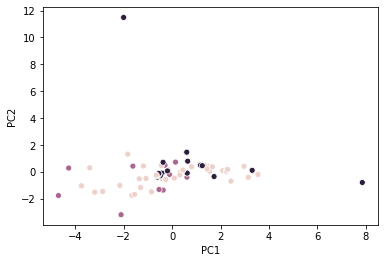

In [16]:
sns.scatterplot(x="PC1", y="PC2", hue="Labels", data=partition_visual,legend=False);

The clusters *generally* appear to be together, although there are some weird outliers--such as the dark purple dot at (-2, 12). It's hard to tell if this is a correct clustering or not, because I'm reducing a 20-D space down to a 2-D space. It's possible that in the greater dimensional plane, that outlier point is actually very close to the rest of the other dark purple points.

## Objective #3: 
*Implement an agglomerative algorithm to cluster the set of active sites.* 

I chose to use single-linkage clustering that relies on minimum distance. Such a clustering method results in long, thin clusters. My rationale here was that I imagined that when sorting active sites based on compositionality, I didn't want to "punish" active sites that had 1 fewer of a certain type of amino acid, because I thought that was likely a meaningless difference. 

More abstractly, I imagine active sites are likely to be classified by categories like "acidic amino acids," "basic amino acids," etc. As a result, in general resemblance in compositionality--which I thought was best captured by minimum distance--should better capture the groups than a more "nit-picky" linkage that heavily punishes what I would consider minor deviations in compositionality (even if the overall amount of basic or charged amino acids stayed the same).

In [17]:
as_num = list(range(0,len(active_site))) #make list of all indices for active sites
group = np.array(as_num) #creating cluster labels
dist_matrix = np.zeros((len(as_num), len(as_num))) # create upper triangular distance matrix recording similarities for each pair of active sites
for row in as_num: #going through rows of distance matrix
    for col in range(row,len(as_num)): #going through columns of distance matrix
        similarity = compute_similarity(active_site[row], active_site[col]) #calculate similarity
        dist_matrix[row, col] = similarity #input the similarity into the proper location in matrix
        
for row in as_num: #NaN-ing redundant values in matrix to make upper triangular matrix
    for col in range(0,row+1):
        dist_matrix[row, col] = np.NaN

In [18]:
def min_similarity(distance_matrix, group_labels):
    '''
    This function determines the the two active sites that are closest to each other and then changes it so those
    points and their associated cluster are converted into one single cluster. It also flags that minimum distance
    so it is never used again in future iterations.
    
    Input: distance_matrix -- a matrix returning all the distances from one active site to another active site
            group_labels -- the current clusters/labels all active sites currently belong to
    
    
    Output: row_i, col_i: the two active sites that are closest to each other
            distance: the minimum distance between those two active sites
    
    '''
    
    flat_i = np.nanargmin(distance_matrix) #finds the "flattened index" of the minimum distance
    row_i = int(flat_i/len(as_num)) #calculates what the row_index or one of the active sites from "flattened index"
    col_i = flat_i - (row_i * len(as_num)) #calculates the col_index or the other active site from "flattened index"
    distance = distance_matrix[row_i, col_i] #is the distance between those two active sites
        
    min_label = np.min([group_labels[row_i], group_labels[col_i]]) #calculates what the lower of the labels of those two active sites are
    max_label = np.max([group_labels[row_i], group_labels[col_i]]) #calculates what the higher of the labels of those two active sites are
    group_labels[np.where(group_labels == max_label)] = min_label #changes all labels of the maxmimum label to the minimum label
                                                                    #basically: combines two clusters into one cluster label
    
    distance_matrix[row_i, col_i] = group_labels[row_i] + 1000 #flagging that distance as "used up"
    
    return row_i, col_i, distance

In [19]:
ele_1, ele_2, dist = min_similarity(dist_matrix, group)

In [20]:
print(ele_1, ele_2)
print(group)

1 20
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19   1  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135]


In [21]:
np.unique(group, return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135]),
 array([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1,

In [22]:
def cluster_hierarchically(active_sites):
    """
    Cluster the given set of ActiveSite instances using a hierarchical algorithm.                                                                  #

    Input: a list of ActiveSite instances
    Output: a list of clusterings
            (each clustering is a list of lists of Sequence objects)
    """
    group = np.array(as_num) #creating cluster labels
    dist_matrix = np.zeros((len(as_num), len(as_num))) # create upper triangular distance matrix recording similarities for each pair of active sites
    for row in as_num: #going through rows of distance matrix
        for col in range(row,len(as_num)): #going through columns of distance matrix
            similarity = compute_similarity(active_site[row], active_site[col]) #calculate similarity
            dist_matrix[row, col] = similarity #input the similarity into the proper location in matrix
        
    for row in as_num: #NaN-ing redundant values in matrix to make upper triangular matrix
        for col in range(0,row+1):
            dist_matrix[row, col] = np.NaN
            
    k = 3 #final number of clusters--set at 3 to better compare to the 3 clusters from Objective 2
    while len(np.unique(group)) > k: #the algorithm will run until I've reached my desired number of clusters
        min_similarity(dist_matrix, group) #calculating
        
    cluster_labels = np.unique(group) #returns a list of arrays of my clusters
    clusterings = []
    for cluster in cluster_labels:
        clusterings.append(np.where(group == cluster))
        ##Note: doing this somehow gave me a list returning tuples that then returns an array
        
        
    #instead turns the previous weird list of tuples of arrays into a list of list of lists (couldn't figure out how to mkae it just a list of lists)
    NN_clusters_list = [] 
    for cluster in clusterings:
        clustering = [l.tolist() for l in cluster]
        NN_clusters_list.append(clustering)
    


    return NN_clusters_list


In [23]:
NN_clusters = cluster_hierarchically(active_site)

In [24]:
NN_clusters

[[[0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80,
   81,
   82,
   83,
   84,
   85,
   86,
   87,
   88,
   89,
   90,
   91,
   92,
   93,
   94,
   95,
   96,
   97,
   98,
   99,
   100,
   101,
   104,
   105,
   106,
   107,
   108,
   109,
   110,
   111,
   112,
   113,
   114,
   115,
   116,
   118,
   119,
   121,
   122,
   123,
   124,
   126,
   127,
   128,
   129,
   130,
   131,
   132,
   133,
   134,
   135]],
 [[18, 19]],
 [[67, 102, 103, 117, 120, 125]]]

I'm visualizing this in a similar way to how I visualized Objective 2--using PCA to reduce 20-D to 2D space.

In [25]:
#using the same PCs I already calculated from my PCA in Objective 2, but I'm now adding labels based 
#off my Objective 3 clustering algorithm rather than Objective 2's.

NN_visual = pd.DataFrame({"PC1": proj_aa[:,0], "PC2": proj_aa[:,1], "Labels": np.NaN})
for i in NN_clusters[0]:
    NN_visual.loc[i, "Labels"] = 0
for i in NN_clusters[1]:
    NN_visual.loc[i, "Labels"] = 1
for i in NN_clusters[2]:
    NN_visual.loc[i, "Labels"] = 2

In [26]:
NN_visual

,PC1,PC2,Labels
0,-1.659441,-1.757551,0.0
1,-4.265214,0.275443,0.0
2,-1.351538,-0.526808,0.0
3,-0.535318,-1.321002,0.0
4,-4.688847,-1.772603,0.0
...,...,...,...
131,-1.615906,0.416515,0.0
132,0.450225,0.124649,0.0
133,-1.615906,0.416515,0.0
134,3.544170,-0.212100,0.0


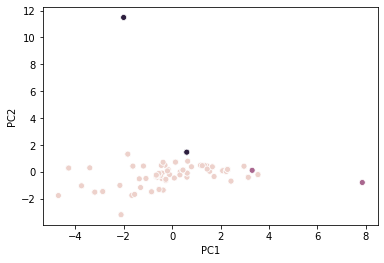

In [27]:
sns.scatterplot(x="PC1", y="PC2", hue="Labels", data=NN_visual, legend=False);

The clusters appear a bit funky--there are two clusters whose points within the cluster are farther away from points in nearby clusters. However, this can probably be attributed to the fact that I performed my clustering in 20-dimensional space while PCA condenses this down to a 2D space, meaning that this plot isn't the best visualization for the distance between these points in their true 20-D space.

## Objective #4: 
*Implement a function to measure the quality of your clusterings.*

I will be implementing something like the Silhouette score to measure my cluster qualities. My goal is as follows: I'm not particularly confident in how my PCA reduced my 20D space, as it now appears that my clusters have greater distance within clusters than outside clusters. By performing Silhouette score in my 20D space, I can see if that is indeed true or not.

As a result, I want my function to return the averages across all 136 active sites of:
-a, the average distances between an active site and all other active sites within the same cluster
-b, the average distances between an active site and all other active sites in different clusters
-s, the absolute value of (1- (a/b)). In this case, s will give an overall Silhouette-like score between 0 and 1 that expresses how close together points within a cluster are to the points outside a cluster. The closer to 1, the more close together points within a cluster are compared to its outside cluster points.

In [28]:
def calculate_a_p(clusterings, df): #calculates avg distance between a point and data points within same cluster
    a_list = []
    for cluster in range(len(clusterings)):
        cluster_pt = cluster
        for activesite in clusterings[cluster]:
            active_site_pt = activesite
            active_site_df = df.loc[df["Site_A"] == active_site_pt, :]
            active_site_2_df = active_site_df.loc[active_site_df["Site_B"].isin(clusterings[cluster_pt])]
            a_list.append(active_site_2_df["Similarity"].mean())
    return a_list #list with the average distance betwen that point and datapoints within same cluster for all points
    
    

In [30]:
a_list = calculate_a_p(partition_cluster, df)
a_list

[0.6016566803798832,
 0.560407742041967,
 0.5933779679349067,
 0.5427430344334903,
 0.535257031933025,
 0.5316926275717512,
 0.48968884267800195,
 0.48968884267800195,
 0.4537498628801053,
 0.48968884267800195,
 0.617049359343355,
 0.6138099911016665,
 0.5231641504238421,
 0.5427430344334903,
 0.617049359343355,
 0.48968884267800195,
 0.44953832782473296,
 0.5687074955492276,
 0.6320121522599689,
 0.48968884267800195,
 0.5316926275717512,
 0.44611475831910413,
 0.44953832782473296,
 0.5844522215413905,
 0.5322405351250961,
 0.5316926275717512,
 0.5316926275717512,
 0.48968884267800195,
 0.44953832782473296,
 0.5027855831425592,
 0.5689597960829442,
 0.48968884267800195,
 0.4572248523497771,
 0.5933779679349067,
 0.6138099911016665,
 0.5590553700773482,
 0.6138099911016665,
 0.48968884267800195,
 0.582848842735846,
 0.44953832782473296,
 0.6320121522599689,
 0.5027855831425592,
 0.624980126529252,
 0.5316926275717512,
 0.5231641504238421,
 0.5316926275717512,
 0.5689597960829442,
 0.536

In [31]:
def calculate_b_p(clusterings, df): #calculates avg distance between a point and data points within same cluster
    b_list = []
    for cluster in range(len(clusterings)):
        cluster_pt = cluster
        for activesite in clusterings[cluster]:
            active_site_pt = activesite
            active_site_df = df.loc[df["Site_A"] == active_site_pt, :]
            active_site_2_df = active_site_df.loc[~active_site_df["Site_B"].isin(clusterings[cluster_pt])]
            b_list.append(active_site_2_df["Similarity"].mean())
    return b_list #list with the average distance betwen that point and datapoints within same cluster for all points

In [32]:
b_list = calculate_b_p(partition_cluster, df)
np.shape(b_list)

(136,)

In [35]:
def pseudo_silhouette_score_p(clusterings, df):
    '''
    See my description right below Objective 4 for a description of what this function does.
    
    Inputs: clusterings -- the outputs from my clustering functions
            df -- a Pandas dataframe containing the distances of every active site to every other active site.
                    I created this in Objective A to make my histogram showing the distribution of all active sites.
    
    Returns: the average a, b, and s across all 136 data points.
    '''
    
    a_list = calculate_a_p(clusterings, df) #returning my list of a values for all 136 active sites
    b_list = calculate_b_p(clusterings, df) #returning my list of b values for all 13t active sites
    
    
    s_list = np.absolute(np.full((len(a_list)), 1) - np.divide(a_list,b_list)) #returning list of s values
    
    #averaging my a, b, and s values to get a number across the whole 136 active point dataset
    a_avg = np.mean(a_list)
    b_avg = np.mean(b_list)
    s_avg = np.mean(s_list)
    
    return a_avg, b_avg, s_avg
    

In [36]:
a, b, s = pseudo_silhouette_score_p(partition_cluster, df)

In [37]:
print("FOR MY PARTITIONING ALGORITHM:")
print("My average a score is:", a)
print("My average b score is:", b)
print("My average s score is:", s)

FOR MY PARTITIONING ALGORITHM:
My average a score is: 0.4903369100423171
My average b score is: 0.6457588460685474
My average s score is: 0.28915901854953624


My paritioning algorithm appears to have a somewhat middling s score, suggesting my clusters don't represent very "bundled" or close-knit values as compared to their surrounding values. Although it's a good sign the average distance within a cluster (a) is lower than the average distance from points outside the cluster (b), a and b are still rather close to each other.

When trying to implmenent this function for my hierarchical clustering, I realize my function is somehow wrapped in another list which I can't seem to get rid of after several hours of debugging. Since I think learning about clustering algorithms and applications is a better use of time than trying to figure out how to turn a list of list of lists into simply a list of list, I am just slightly rewriting my code for use with my hierarchical function.

In [41]:
def calculate_a_h(clusterings, df): #calculates avg distance between a point and data points within same cluster
    a_list = []
    for cluster in range(len(clusterings)):
        cluster_pt = cluster
        for extralist in range(len(clusterings[cluster])):
            for activesite in clusterings[cluster][extralist]:
                active_site_pt = activesite
                active_site_df = df.loc[df["Site_A"] == active_site_pt, :]
                active_site_2_df = active_site_df.loc[active_site_df["Site_B"].isin(clusterings[cluster_pt][extralist])]
                a_list.append(active_site_2_df["Similarity"].mean())
    return a_list #list with the average distance betwen that point and datapoints within same cluster for all points

In [42]:
calculate_a_h(NN_clusters, df)

[0.567585450424485,
 0.49432770836445017,
 0.4997921613201636,
 0.5335119135928769,
 0.49192638825861573,
 0.5403947074201773,
 0.4909406849974741,
 0.5420229199429518,
 0.4835399526845981,
 0.6542593034911973,
 0.5867523506721227,
 0.577257604903362,
 0.5867523506721227,
 0.4473286684169119,
 0.5867523506721227,
 0.6070407475871742,
 0.5768955872021533,
 0.5017582776314892,
 0.49432770836445017,
 0.5745356885353529,
 0.5743319000904239,
 0.5847253122540372,
 0.4909406849974741,
 0.5459647494034146,
 0.6070407475871742,
 0.5867523506721227,
 0.5265996651067435,
 0.49432770836445017,
 0.49432770836445017,
 0.5254028369171484,
 0.6118628955180362,
 0.5867523506721227,
 0.49432770836445017,
 0.5784101390430887,
 0.6542593034911973,
 0.5058578652081532,
 0.5265996651067435,
 0.5397192660620189,
 0.577257604903362,
 0.5483065167743487,
 0.6219519370123383,
 0.6542593034911973,
 0.6542593034911973,
 0.5867523506721227,
 0.5265996651067435,
 0.5899871337760372,
 0.49432770836445017,
 0.539719

In [43]:
np.mean(calculate_a_p(partition_cluster, df))

0.4903369100423171

In [44]:
def calculate_b_h(clusterings, df): #calculates avg distance between a point and data points within same cluster
    b_list = []
    for cluster in range(len(clusterings)):
        cluster_pt = cluster
        for extralist in range(len(clusterings[cluster])):
            for activesite in clusterings[cluster][extralist]:
                active_site_pt = activesite
                active_site_df = df.loc[df["Site_A"] == active_site_pt, :]
                active_site_2_df = active_site_df.loc[~active_site_df["Site_B"].isin(clusterings[cluster_pt][extralist])]
                b_list.append(active_site_2_df["Similarity"].mean())
    return b_list #list with the average distance betwen that point and datapoints within same cluster for all points

In [45]:
def pseudo_silhouette_score_h(clusterings, df):
    '''
    This function is for my hierarchical clustering algorithm. See my description right below Objective 4 for a description of what this function does.
    
    Inputs: clusterings -- the outputs from my clustering functions
            df -- a Pandas dataframe containing the distances of every active site to every other active site.
                    I created this in Objective A to make my histogram showing the distribution of all active sites.
    
    Returns: the average a, b, and s across all 136 data points.
    '''
    
    a_list = calculate_a_h(clusterings, df) #returning my list of a values for all 136 active sites
    b_list = calculate_b_h(clusterings, df) #returning my list of b values for all 13t active sites
    
    
    s_list = np.absolute(np.full((len(a_list)), 1) - np.divide(a_list,b_list)) #returning list of s values
    
    #averaging my a, b, and s values to get a number across the whole 136 active point dataset
    a_avg = np.mean(a_list)
    b_avg = np.mean(b_list)
    s_avg = np.mean(s_list)
    
    return a_avg, b_avg, s_avg

In [46]:
ac, bc, sc = pseudo_silhouette_score_h(NN_clusters, df)

In [47]:
print("FOR MY HIERARCHICAL ALGORITHM:")
print("My average a score is:", ac)
print("My average b score is:", bc)
print("My average s score is:", sc)

FOR MY HIERARCHICAL ALGORITHM:
My average a score is: 0.5406375012986019
My average b score is: 0.7592778131526741
My average s score is: 0.28688251228457673


My hierarchical algorithm appears to have an even worse s score, again suggesting my clusters don't represent very "bundled" or close-knit values as compared to their surrounding values. Although it's a good sign the average distance within a cluster (a) is lower than the average distance from points outside the cluster (b), a is worse than in my other algorithm and a and b are still rather close to each other.

## Objective #5: 
*Implement a function to compare your two clusterings*

I plan to use the Jaccard coefficient, which is a way of measuring how similar two sample sets are. It returns a value between 0 and 1, with 1 being that the sets are the same and 0 the most dissimilar.

I can perform the Jaccard coefficient to compare each of my clusters to its "corresponding" cluster for the other algorithm. To pick "corresponding" clusters, I'm simply going to choose the clusters which are closest in length to each other, i.e. the largest hierarchical cluster will be compared to the largest partitioning cluster.

In [48]:
print(np.size(partition_cluster[0]))
print(np.size(partition_cluster[1]))
print(np.size(partition_cluster[2]))

85
27
24


In [49]:
print(np.size(NN_clusters[0][0]))
print(np.size(NN_clusters[1][0]))
print(np.size(NN_clusters[2][0]))

128
2
6


In [50]:
def jac_coef(cluster1, cluster2):
    s1 = set(cluster1)
    s2 = set(cluster2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [51]:
cluster0 = jac_coef(partition_cluster[0], NN_clusters[0][0])
cluster0

0.6640625

In [52]:
cluster1 = jac_coef(partition_cluster[1], NN_clusters[1][0])
cluster1

0.0

In [53]:
cluster2 = jac_coef(partition_cluster[2], NN_clusters[2][0])
cluster2

0.25

My values of 0.66, 0, and 0.25 inform me that my clustering methods resulted in fairly dissimilar clusters, which was very unexpected. I expect that if I'd randomized the centroids for my paritioning clustering method differently, I could have easily gotten different clusters. This is likely why researchers will implement or repeat K-Means many times with different centroids values. However, given the amount of time I had to devote to debugging different parts of my homework, I simply did not have the time to implement this extra "repeat K-Means with different centroids and take the average of my results" method.

### Did your clusterings have any biological meaning? 

Based on the fact that my two different clustering algorithms appeared to cluster very differently from each other despite using the same "similarity metric" based on the jaccard coefficient, my semi-Silhouette score suggests poor quality, and my own visual inspection of my clusters following compression of my 20-D to 2-D space also gives me odd-to-interpret clusters, I am very hesitatnt to assign any true biological meaning to either of the clusters I produced using my paritioning or hierarchical clustering algorithm. However, given that some of my potential clusters--specifically cluster 1 and cluster 2 in my hierarchical clustering--had very few active sites, it is fairly straightfoward for me to visually inspect them to see if they appear to be at all similar.

For Cluster 1 in Hierarhcial Clustering, there is only active site 18 and active site 19. The compositions of these two active sites are below:

In [54]:
print("Active Site 18:",active_site[18].residues)
print("Active Site 19:", active_site[19].residues)

Active Site 18: [HIS 66, GLY 110, TYR 140, HIS 66, GLY 110, TYR 140, HIS 66, GLY 110, TYR 140]
Active Site 19: [HIS 66, GLY 110, TYR 140]


Indeed, both active sites consist of only histidine, glycine, and tyrosine--in fact, they even have the same composition of his, gly, and tyr. The difference between the two active sites in this cluster is only that Active Site 18 is larger, something that is NOT captured by the similarity metric I chose to implement.

For Cluster 2 in Hierarchical Clustering, there are active sites 67, 102, 103, 117, 120, and 125.

In [55]:
print("Active Site 67:",active_site[67].residues)
print("Active Site 102:", active_site[102].residues)
print("Active Site 103:",active_site[103].residues)
print("Active Site 117:", active_site[117].residues)
print("Active Site 120:",active_site[120].residues)
print("Active Site 125:", active_site[125].residues)

Active Site 67: [ALA 98, GLY 141, GLU 144, GLU 164, ALA 98, GLY 141, GLU 144, GLU 164, ALA 98, GLY 141, GLU 144, GLU 164, ALA 98, GLY 141, GLU 144, GLU 164, ALA 98, GLY 141, GLU 144, GLU 164, ALA 98, GLY 141, GLU 144, GLU 164]
Active Site 102: [ALA 70, LEU 126, GLU 158]
Active Site 103: [ALA 98, GLY 141, GLU 144, GLU 164, ALA 98, GLY 141, GLU 144, GLU 164, ALA 98, GLY 141, GLU 144, GLU 164, ALA 98, GLY 141, GLU 144, GLU 164, ALA 98, GLY 141, GLU 144, GLU 164, ALA 98, GLY 141, GLU 144, GLU 164]
Active Site 117: [ALA 70, LEU 126, GLU 158]
Active Site 120: [ALA 98, GLY 141, GLU 144, GLU 164, ALA 98, GLY 141, GLU 144, GLU 164, ALA 98, GLY 141, GLU 144, GLU 164, ALA 98, GLY 141, GLU 144, GLU 164, ALA 98, GLY 141, GLU 144, GLU 164, ALA 98, GLY 141, GLU 144, GLU 164]
Active Site 125: [ALA 98, GLY 141, GLU 144, GLU 164, ALA 98, GLY 141, GLU 144, GLU 164, ALA 98, GLY 141, GLU 144, GLU 164, ALA 98, GLY 141, GLU 144, GLU 164, ALA 98, GLY 141, GLU 144, GLU 164, ALA 98, GLY 141, GLU 144, GLU 164]


These six active sites all appear to have high concentrations of Ala and Glu. Additionally, active sites then either also had some more Leu or some more Gly. As a result, this particular clustering could perhaps suggest that combinations of Ala, Leu, and Glu or Ala, Gly, and Glu have similar roles, although more experimentation is needed to back that up.


Nonetheless, even if I ignore my clusterings, I can still extract biological meaning from this homework using my similarity metric. In particular, my histogram of all distances from my similarity metric suggests possible biological meanings. For example: there are quite a lot of active sites showing ZERO distance, meaning that a lot of compositionality within active sites can be conserved.